###  Part 2 - Supervised learning on MNIST- Fashion Dataset - Convolutional Neural Networks

In [1]:
# importing essential libraries

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

import timeit

#### Reproducibility and Readability
To ensure reproducibility of the results, a seed value is set in appropriate cells. This is done to avoid running the entire sheet from the beginning each time while writing the code for different sections.
Comments are also included in relavent cells to describe the code.

#### Data Loading 

In [6]:
# Loading Training and Testing datasets from torchvision.datasets module with image normalization:
transform_data = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))]) 
# the dataset images are Grayscale, the number of channels will be 1. So a single value for mean and std.deviation has been 
# assigned in transforms.Normalize

train_data_T = datasets.FashionMNIST(root = './data', download = False,  # set True to download the data
                                     train = True, transform = transform_data)

test_data_T = datasets.FashionMNIST(root = './data', download = False, 
                                    train = False, transform = transform_data)

batchsize = 10
torch.manual_seed(1748471)

# Loaders for data with normalization
train_data_T_loader = torch.utils.data.DataLoader(train_data_T, shuffle = True, batch_size = batchsize, num_workers = 2)
test_data_T_loader = torch.utils.data.DataLoader(test_data_T, shuffle = False, batch_size = batchsize, num_workers = 2)

Basic dataset exploration has been carried out in the Part1 which can be refered from the link below:




https://github.com/vishnu-ek/PART-1--Supervised-learning-on-FashionMNIST-dataset-using-Logistic-Regression.git

#### Evaluation metrics 
Training accuracy, testing accuracy, number of learnable parameters and training time are determined for the Logistic Regression models. They can be found in the following section

#### Convolutional neural networks

In [18]:
from sklearn.metrics import confusion_matrix

def con_matrix(true_list, pre_list, title):
    con_df = pd.DataFrame(confusion_matrix(true_list, pre_list), columns = train_data_T.classes, index = train_data_T.classes)
    plt.figure(figsize = (10,5))
    plt.title(title)
    sns.heatmap(con_df, annot = True, fmt = "d")

##### Function for training the CNN model

In [10]:
def training_fn_nn(epoc, criteria, optimiser, model, loader, data):
    print(data)
    
    start = timeit.default_timer() # Starting the timer
    for iteration in range(epoc):
        loss_tracking = 0
        for i,j in enumerate(loader):
            image, label = j # loading a batch of input train data
            optimiser.zero_grad()
            predictions = model(image)
            loss = criteria(predictions, label)
            
            loss.backward() # back propogating the losses
            optimiser.step()
            
            loss_tracking += loss.item() # Computing the average loss for 2000 iterations
            if i%2000 == 0:
                print('epoch:',iteration,'\t','instance:',i,'\t','Avg loss:',loss_tracking/2000)
                loss_tracking = 0
                
    print("Training is done!\n")
    
    # Determining the time taken to train the model
    total_time = timeit.default_timer() - start
    print("Model training time:", total_time) 
    
    # Determining the learnable parameters in the model
    no_of_para = 0
    for i in list(model.parameters()):
        no_of_para += torch.tensor(i.size()).prod().item()
    print("No of Model parameters:",no_of_para)
    
    return (total_time, no_of_para)

##### Function for testing the prediction accuracy of the CNN model

In [12]:
def testing_fn_nn(model, loader, data):
    actual = []
    prediction = []
    torch.manual_seed(1748471)
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad(): # Setting nograd to prevent unnecessary loss of computational time and memory. 
        for i in loader:
            image, label = i
            test_out = model(image)
            _, test_prediction_index = torch.max(test_out.data, 1)# getting the max prediction values 
# and their indexes for a batch of data
            total_predictions += label.size(0)
            
            correct_predictions += (test_prediction_index == label).sum().item() # calculating the total number
# of correct predictions
            actual.extend(label)
            prediction.extend(test_prediction_index)
        
    acc = correct_predictions / total_predictions*100
    print(data, acc,'%')
    return (actual, prediction, acc)

##### Two Convolutional layers and two fully connected layers 

In [14]:
# Two convolutional layers and two fully connected layers
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.con1 = nn.Conv2d(1,7,5)
        self.pool = nn.MaxPool2d(2,2)
        self.con2 = nn.Conv2d(7,10,5)
        self.linear1 = nn.Linear(10*4*4, 50)
        self.linear2 = nn.Linear(50, 10)
    def forward(self,x):
        x = self.pool(F.relu(self.con1(x)))
        x = self.pool(F.relu(self.con2(x)))
        x = x.view(-1,10*4*4)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

In [15]:
torch.manual_seed(1748471)
neural_network = NeuralNetwork()

training CNN model 2CNN & 2 fully connected layers 

epoch: 0 	 instance: 0 	 Avg loss: 5.408188700675964e-05
epoch: 0 	 instance: 2000 	 Avg loss: 0.4213446104079485
epoch: 0 	 instance: 4000 	 Avg loss: 0.40779580796766096
Training is done!

Model training time: 57.97690454700023
No of Model parameters: 10502
Prediction accuracy for training data: 86.75 %
Prediction accuracy for test data: 86.11999999999999 %


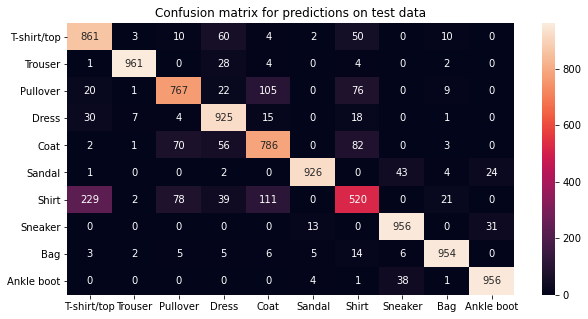

In [19]:
nn_criterion = nn.CrossEntropyLoss()
nn_optimizer = optim.SGD(neural_network.parameters(), lr = 0.001, momentum = 0.9)
epoch = 1
data = "training CNN model 2CNN & 2 fully connected layers \n"

# calling the training function
time_CNN, para_CNN = training_fn_nn(epoch, nn_criterion, nn_optimizer, neural_network, train_data_T_loader, data)


# Testing the CNN model on train data(part a)
data = "Prediction accuracy for training data:"
_,_,train_acc_CNN = testing_fn_nn(neural_network, train_data_T_loader, data)

# Testing the CNN model on test data(part a)
data = "Prediction accuracy for test data:"
actual, prediction, test_acc_CNN = testing_fn_nn(neural_network, test_data_T_loader, data)
title = "Confusion matrix for predictions on test data"
con_matrix(actual, prediction, title)

##### Two Convolutional layers and five fully connected layers 

In [20]:
# Two convolutional layers and five fully connected layers
class NeuralNetwork1(nn.Module):
    def __init__(self):
        super(NeuralNetwork1, self).__init__()
        self.con1 = nn.Conv2d(1,7,5)
        self.pool = nn.MaxPool2d(2,2)
        self.con2 = nn.Conv2d(7,12,5)
        self.linear1 = nn.Linear(12*4*4,150)
        self.linear2 = nn.Linear(150, 110)
        self.linear3 = nn.Linear(110, 80)
        self.linear4 = nn.Linear(80, 50)
        self.linear5 = nn.Linear(50, 10)
    def forward(self,x):
        x = self.pool(F.relu(self.con1(x)))
        x = self.pool(F.relu(self.con2(x)))
        x = x.view(-1, 12*4*4)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = F.relu(self.linear3(x))
        x = F.relu(self.linear4(x))
        x = self.linear5(x)
        return x

In [21]:
torch.manual_seed(1748471)
neural_network1 = NeuralNetwork1()

training CNN model, 2CNN and 5 fully connected layers 

epoch: 0 	 instance: 0 	 Avg loss: 0.001159938097000122
epoch: 0 	 instance: 2000 	 Avg loss: 2.3011643940210345
epoch: 0 	 instance: 4000 	 Avg loss: 1.7584228510409594
Training is done!

Model training time: 69.52699159599979
No of Model parameters: 61294
Prediction accuracy for training data: 74.29333333333334 %
Prediction accuracy for test data: 73.72 %


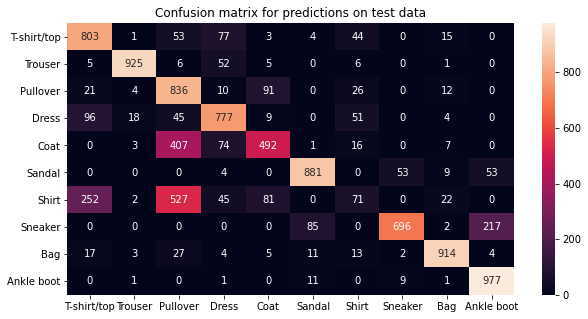

In [23]:
nn_optimizer1 = optim.SGD(neural_network1.parameters(), lr = 0.001, momentum = 0.9)
epoch = 1
data = "training CNN model, 2CNN and 5 fully connected layers \n"

# calling the training function
time_CNN1, para_CNN1 = training_fn_nn(epoch, nn_criterion, nn_optimizer1, neural_network1, train_data_T_loader, data)


# Testing the CNN model on train data(part b)
data = "Prediction accuracy for training data:"
_,_,train_acc_CNN1 = testing_fn_nn(neural_network1, train_data_T_loader, data)

# Testing the CNN model on test data(part b)
data = "Prediction accuracy for test data:"
actual, prediction, test_acc_CNN1 = testing_fn_nn(neural_network1, test_data_T_loader, data)
title = "Confusion matrix for predictions on test data"
con_matrix(actual, prediction, title)

##### Five Convolutional layers and two fully connected layers 

In [24]:
# Five convolutional layers and Two fully connected layers
class NeuralNetwork2(nn.Module):
    def __init__(self):
        super(NeuralNetwork2, self).__init__()
        self.con1 = nn.Conv2d(1,10,5) 
        self.con2 = nn.Conv2d(10,12,5)
        self.con3 = nn.Conv2d(12,14,5)
        self.con4 = nn.Conv2d(14,16,5)
        self.con5 = nn.Conv2d(16,18,5)
        self.pool = nn.MaxPool2d(2,2)
        self.linear1 = nn.Linear(18*4*4, 100)
        self.linear2 = nn.Linear(100,10)
    def forward(self,x):
        x = F.relu(self.con1(x))
        x = F.relu(self.con2(x))
        x = F.relu(self.con3(x))
        x = F.relu(self.con4(x))
        x = self.pool(F.relu(self.con5(x)))
        x = x.view(-1,18*4*4)
        x = F.relu(self.linear1(x))
        x = self.linear2(x)
        return x

In [25]:
torch.manual_seed(1748471)
neural_network2 = NeuralNetwork2()

training CNN model, 5 CNN and 2 fully connected layers 

epoch: 0 	 instance: 0 	 Avg loss: 0.0005128351449966431
epoch: 0 	 instance: 2000 	 Avg loss: 0.6810814329115674
epoch: 0 	 instance: 4000 	 Avg loss: 0.5932187109235674
Training is done!

Model training time: 137.26515017700058
No of Model parameters: 50230
Prediction accuracy for training data: 82.70333333333333 %
Prediction accuracy for test data: 82.23 %


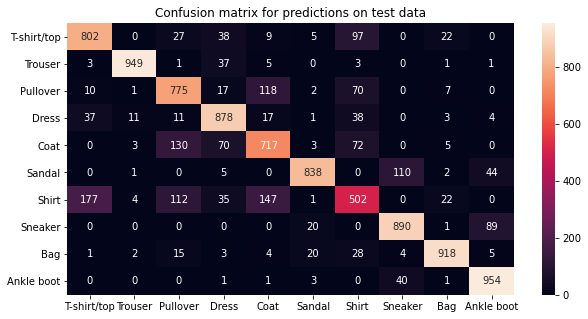

In [27]:
nn_optimizer2 = optim.SGD(neural_network2.parameters(), lr = 0.001, momentum = 0.9)
epoch = 1
data = "training CNN model, 5 CNN and 2 fully connected layers \n"

# calling the training function
time_CNN2, para_CNN2 = training_fn_nn(epoch, nn_criterion, nn_optimizer2, neural_network2, train_data_T_loader, data)


# Testing the CNN model on train data(part c)
data = "Prediction accuracy for training data:"
_,_, train_acc_CNN2 = testing_fn_nn(neural_network2, train_data_T_loader, data)

# Testing the CNN model on test data(part c)
data = "Prediction accuracy for test data:"
actual, prediction, test_acc_CNN2 = testing_fn_nn(neural_network2, test_data_T_loader, data)
title = "Confusion matrix for predictions on test data"
con_matrix(actual, prediction, title)

#### Performance comparison

In [28]:
# Creating a dataframe of the performance metrics
column_name = ["2CNN & 2fully CL","2CNN & 5 fully CL","5 CNN & 2 fully CL"]
row_name = ["Training_acc", "Testing_acc", "Training_time", "No_of_parameters"]

perf_matrix = np.array([[train_acc_CNN, train_acc_CNN1, train_acc_CNN2],\
                       [test_acc_CNN, test_acc_CNN1, test_acc_CNN2 ],\
                       [time_CNN, time_CNN1, time_CNN2],\
                       [para_CNN, para_CNN1, para_CNN2]])
perf_df = pd.DataFrame(perf_matrix, columns = column_name, index = row_name)

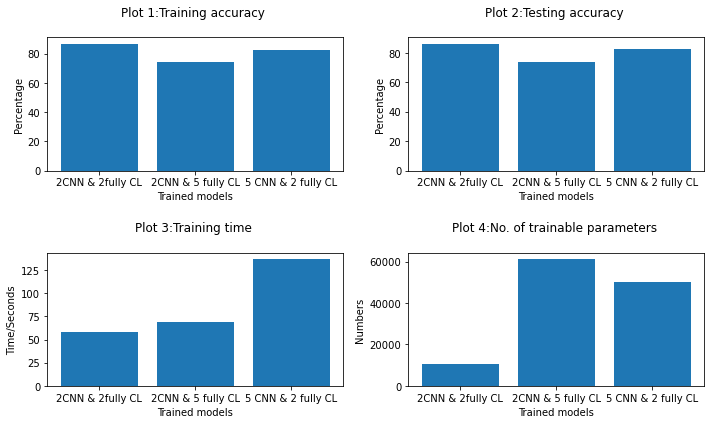

In [30]:
# Training Accuracy
plt.figure(figsize = (10,6))
plt.subplot(2,2,1)
plt.title("Plot 1:Training accuracy \n")
plt.xlabel("Trained models")
plt.ylabel("Percentage")
plt.bar(column_name, perf_df.loc["Training_acc"])

#Testing Accuracy
plt.subplot(2,2,2)
plt.title("Plot 2:Testing accuracy \n ")
plt.xlabel("Trained models")
plt.ylabel("Percentage")
plt.bar(column_name, perf_df.loc["Testing_acc"])

# Time taken for learning
plt.subplot(2,2,3)
plt.title("Plot 3:Training time \n")
plt.xlabel("Trained models")
plt.ylabel("Time/Seconds")
plt.bar(column_name, perf_df.loc["Training_time"])

# No. of learnable parameters
plt.subplot(2,2,4)
plt.title("Plot 4:No. of trainable parameters \n")
plt.xlabel("Trained models")
plt.ylabel("Numbers")
plt.bar(column_name, perf_df.loc["No_of_parameters"])
plt.tight_layout(h_pad = 2)
plt.show()

<b>Observation:</b>

Time taken to train a model is proportional to the number of convolutional layers present in the model. It may be intutive to think that the time taken to train a model is proportional to the number of learnable parameters present in the model. However it's not the case. From the the plot 4 it can be seen that the CNN with 5 convolutional layers and 2 fully connected layers has less number of learnable parameters than the CNN with 2 convolutional layers and 5 fully connected layers, but the time taken to train the former model is higher than the later. This mean that the process of back propogating the losses in each iteration is costly in terms of computational time.

Also the prediction accuracy of the models can further be increased by increasing the number of epochs